In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import cmocean
import scipy.io as sio
import geopandas as gpd
import rioxarray

# Load IceSAT/IceSAT2 dh/dt mosaic from Smith et al. 2020

In [2]:
da = xr.open_rasterio('./ICESat1_ICESat2_mass_change/ais_grounded.tif')
#for some reason there appears to be a systematic offset (stretching) between 
#the built-in cartopy projection and the coordinates in smith 2020
y = 1.03*da[0].y
x = 1.03*da[0].x

dhdt = da.variable.data[0]
#transform = Affine.from_gdal(*da.attrs['transform'])

xx, yy = np.meshgrid(x, y)

/usr/local/anaconda3/envs/exfilmap/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  """Entry point for launching an IPython kernel.


# Calculate Exfiltration Prediction

In [3]:
year = 3600*24*365
rhoi = 920
rhow = 1000
g = 9.81
mu_w = 1e-3

perm=1e-13
K_t = perm*rhow*g/mu_w
S = 1e-6
xi = 0.2

deltat = 16*year
exfil_analytic = -2*(1-xi)*(rhoi/rhow)*dhdt*(K_t*S*deltat/np.pi)**0.5

Text(0, 0.5, 'Exfiltration Rate (mm/yr)')

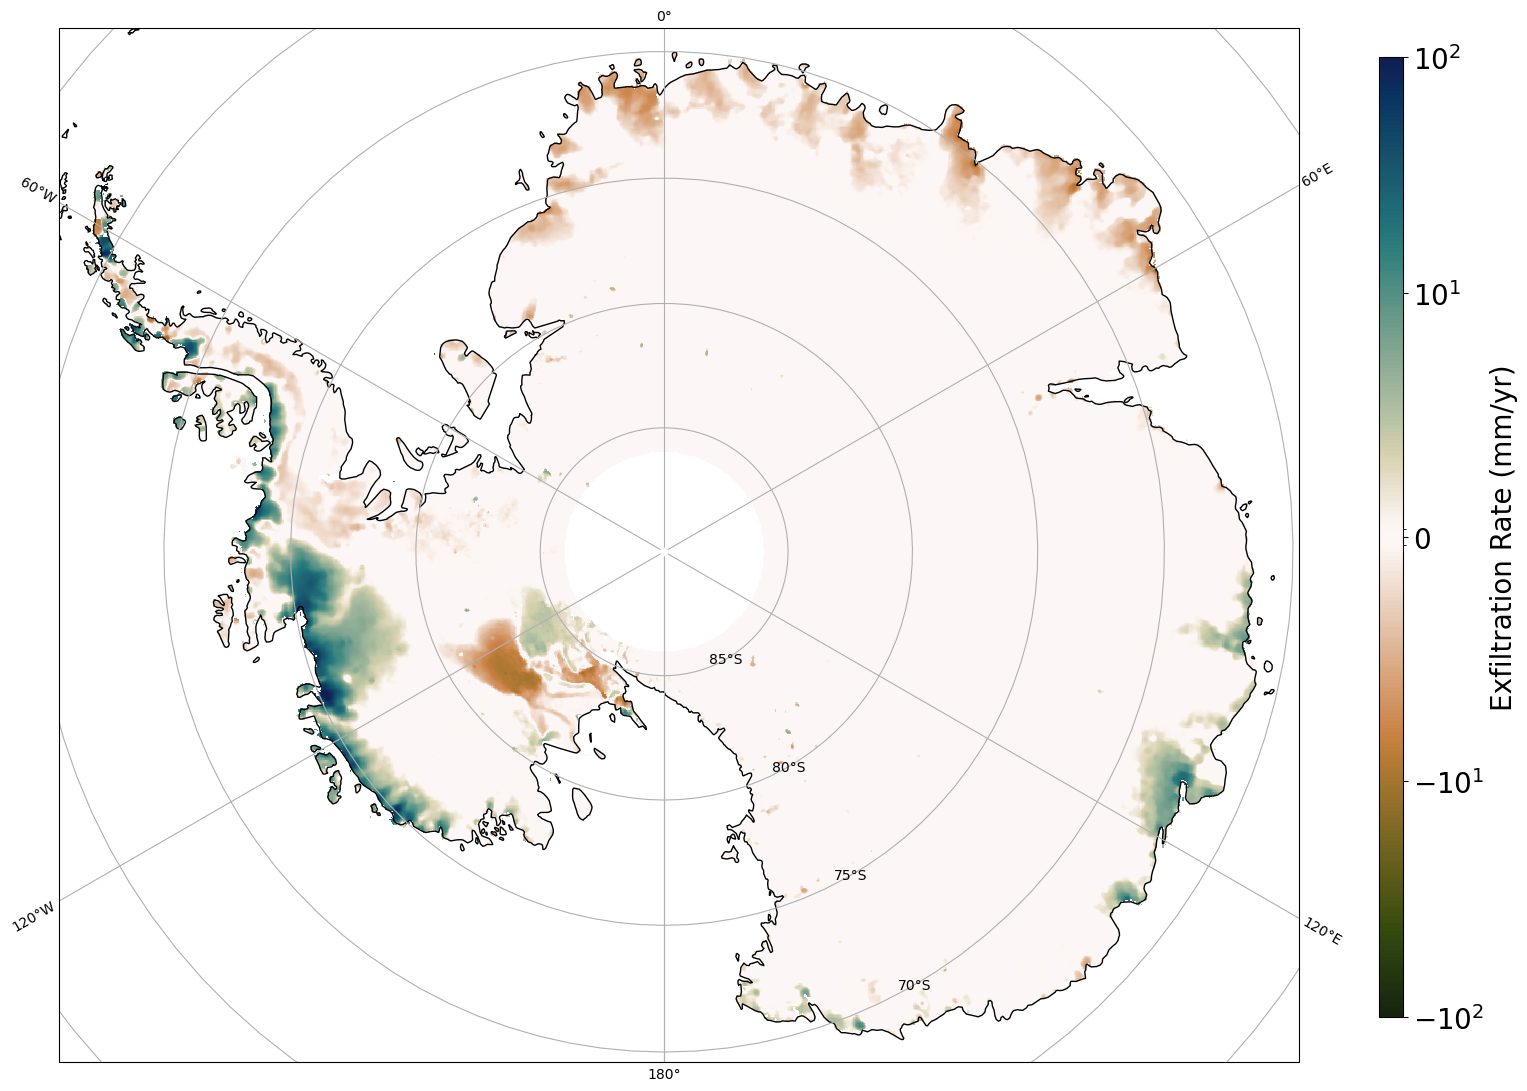

In [4]:
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(16, 16))
ax = plt.subplot(1, 1, 1, projection=projection)
p1 = ax.pcolormesh(xx, yy, 1000*exfil_analytic, cmap=cmocean.cm.tarn, norm=colors.SymLogNorm(linthresh=1.0, linscale=0.03,
                                              vmin=-100, vmax=100) )
ax.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
ax.coastlines()
ax.gridlines(draw_labels=True)

cax = plt.axes([0.95, 0.2, 0.015, 0.6])
cb = plt.colorbar(p1, cax=cax, orientation='vertical',ticks=[-100, -10, 0, 10, 100])
cb.ax.tick_params(axis='both', which='major', labelsize=20)
cb.ax.set_ylabel('Exfiltration Rate (mm/yr)',fontsize=20)

#plt.savefig('IceSat2_thinningexfil_perm1e-13_justprediction_v1.png', bbox_inches='tight')

### Only execute the next three to calculate sums

In [4]:
iceshelvesmask = gpd.read_file('iceShelves.geojson')
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'}); 

da_wais = da.rio.clip(icems.loc[[4],'geometry'])
dhdt_wais = da_wais.variable.data[0]

da_thwaites = da.rio.clip(icems.loc[[26],'geometry'])
dhdt_thwaites = da_thwaites.variable.data[0]

da_pig = da.rio.clip(icems.loc[[27],'geometry'])
dhdt_pig = da_pig.variable.data[0]

/usr/local/anaconda3/envs/exfilmap/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
Warning 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.


In [5]:
exfil_analytic_wais = -2*(1-xi)*(rhoi/rhow)*dhdt_wais*(K_t*S*deltat/np.pi)**0.5
exfil_analytic_thwaites = -2*(1-xi)*(rhoi/rhow)*dhdt_thwaites*(K_t*S*deltat/np.pi)**0.5
exfil_analytic_pig = -2*(1-xi)*(rhoi/rhow)*dhdt_pig*(K_t*S*deltat/np.pi)**0.5

In [6]:
#sums
exfil_analytic_justex = exfil_analytic
exfil_analytic_justex[dhdt>0] = np.nan
exfil_aa = np.nansum(exfil_analytic_justex*(5e3**2))*1000/1e12

exfil_analytic_justex_wais = exfil_analytic_wais
exfil_analytic_justex_wais[dhdt_wais>0] = np.nan
exfil_wais = np.nansum(exfil_analytic_justex_wais*(5e3**2))*1000/1e12

exfil_analytic_justex_thwaites = exfil_analytic_thwaites
exfil_analytic_justex_thwaites[dhdt_thwaites>0] = np.nan
exfil_thwaites = np.nansum(exfil_analytic_justex_thwaites*(5e3**2))*1000/1e12

exfil_analytic_justex_pig = exfil_analytic_pig
exfil_analytic_justex_pig[dhdt_pig>0] = np.nan
exfil_pig = np.nansum(exfil_analytic_justex_pig*(5e3**2))*1000/1e12

exfil_ase = exfil_thwaites + exfil_pig

# Fraction of subglacial water budget (Pattyn 2010)

In [7]:
mat_contents = sio.loadmat('Pattyn2010_basalmelt_mean_smithgrid.mat',struct_as_record=False)
bmr = mat_contents['basalmelt_smithgrid']

exfilfrac_basalmelt = exfil_analytic/(bmr+exfil_analytic)
#x_pattyn = np.arange(-2800000,2805000,5000)
#xx_pattyn,yy_pattyn = np.meshgrid(x_pattyn,x_pattyn)

In [ ]:
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(16, 16))
ax = plt.subplot(1, 1, 1, projection=projection)
p1 = ax.pcolormesh(xx, yy, 1000*bmr, cmap=cmocean.cm.dense, norm=colors.LogNorm(vmin=1, vmax=100) )
ax.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
ax.coastlines()
ax.gridlines(draw_labels=True)

cax = plt.axes([0.95, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=cax, orientation='vertical',ticks=[-100, -10, 0, 10, 100])
cb.ax.set_ylabel('Basal Melt Rate (mm/yr)',fontsize=24);

In [ ]:
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(16, 16))
ax = plt.subplot(1, 1, 1, projection=projection)
p1 = ax.pcolormesh(xx, yy, exfilfrac_basalmelt, cmap='PRGn',vmin=-1,vmax=1)
ax.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
ax.coastlines()
ax.gridlines(draw_labels=True)

cax = plt.axes([0.95, 0.2, 0.015, 0.6])
cb = plt.colorbar(p1, cax=cax, orientation='vertical')
cb.ax.tick_params(axis='both', which='major', labelsize=20)
cb.ax.set_ylabel('Exfiltration rate fraction of total water budget',fontsize=24);

#plt.savefig('IceSat2_thinningexfil_perm1e-13_justexfilfrac_v1.png', bbox_inches='tight')

# All panels together now

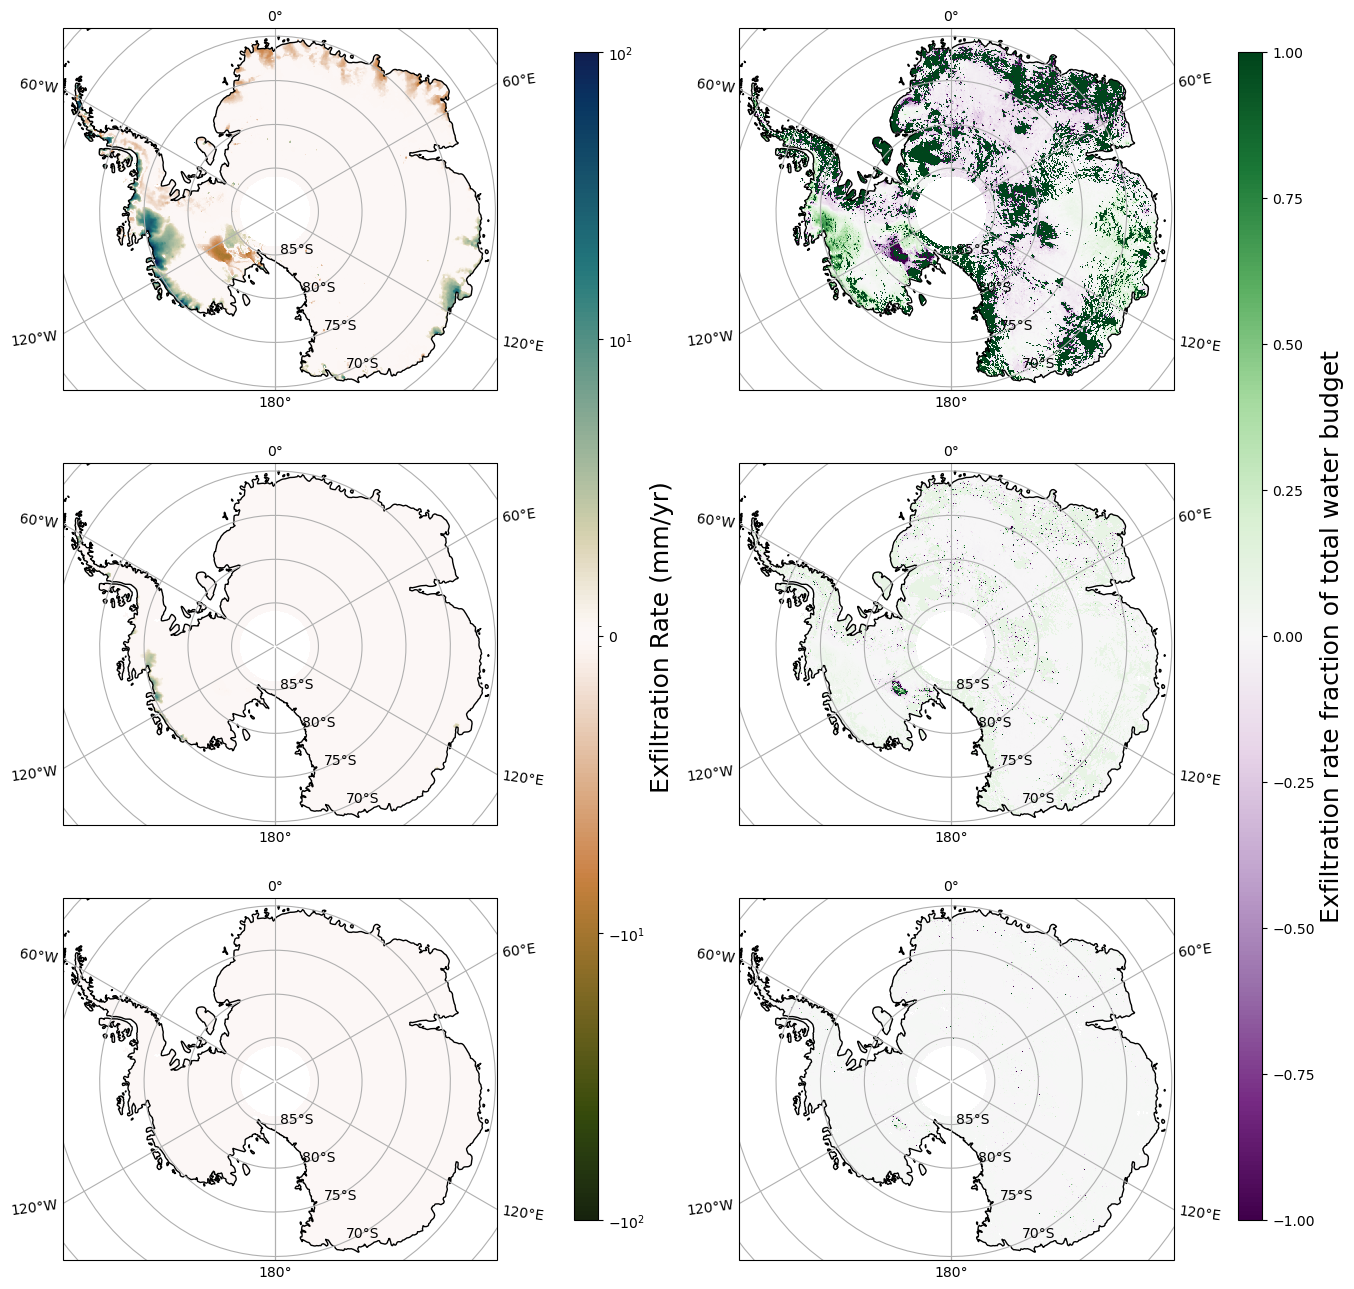

In [44]:
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(16, 16))
ax1 = plt.subplot(3, 2, 1, projection=projection)
p1 = ax1.pcolormesh(xx, yy, 1000*exfil_analytic, cmap=cmocean.cm.tarn, norm=colors.SymLogNorm(linthresh=1.0, linscale=0.03,
                                              vmin=-100, vmax=100) )
ax1.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
ax1.coastlines()
ax1.gridlines(draw_labels=True)
#ax1.text(-0.07, 0.55, '$k=10^{-13}$ m$^2$', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax1.transAxes, fontsize=24)
#ax1.text(0.05, 0.9, '(a)', va='bottom', ha='center',transform=ax1.transAxes, fontsize=20)

ax3 = plt.subplot(3, 2, 3, projection=projection)
p3 = ax3.pcolormesh(xx, yy, 1000*exfil_analytic/10, cmap=cmocean.cm.tarn, norm=colors.SymLogNorm(linthresh=1.0, linscale=0.03,
                                              vmin=-100, vmax=100) )
ax3.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
ax3.coastlines()
ax3.gridlines(draw_labels=True)
#ax3.text(-0.07, 0.55, '$k=10^{-15}$ m$^2$', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax3.transAxes, fontsize=24)
#ax3.text(0.05, 0.9, '(b)', va='bottom', ha='center',transform=ax3.transAxes, fontsize=20)

ax5 = plt.subplot(3, 2, 5, projection=projection)
p5 = ax5.pcolormesh(xx, yy, 1000*exfil_analytic/100, cmap=cmocean.cm.tarn, norm=colors.SymLogNorm(linthresh=1.0, linscale=0.03,
                                              vmin=-100, vmax=100) )
ax5.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
ax5.coastlines()
ax5.gridlines(draw_labels=True)
#ax5.text(-0.07, 0.55, '$k=10^{-17}$ m$^2$', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax5.transAxes, fontsize=24)
#ax5.text(0.05, 0.9, '(c)', va='bottom', ha='center',transform=ax5.transAxes, fontsize=20)

cax1 = plt.axes([0.485, 0.135, 0.015, 0.73])
cb1 = plt.colorbar(p1, cax=cax1, orientation='vertical',ticks=[-100, -10, 0, 10, 100])
cb1.ax.set_ylabel('Exfiltration Rate (mm/yr)',fontsize=18)

ax2 = plt.subplot(3, 2, 2, projection=projection)
p2 = ax2.pcolormesh(xx, yy, exfilfrac_basalmelt, cmap='PRGn',vmin=-1,vmax=1)
ax2.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
ax2.coastlines()
ax2.gridlines(draw_labels=True)
#ax2.text(0.05, 0.9, '(d)', va='bottom', ha='center',transform=ax2.transAxes, fontsize=20)

ax4 = plt.subplot(3, 2, 4, projection=projection)
p4 = ax4.pcolormesh(xx, yy, exfilfrac_basalmelt/10, cmap='PRGn',vmin=-1,vmax=1)
ax4.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
ax4.coastlines()
ax4.gridlines(draw_labels=True)
#ax4.text(0.05, 0.9, '(e)', va='bottom', ha='center',transform=ax4.transAxes, fontsize=20)

ax6 = plt.subplot(3, 2, 6, projection=projection)
p6 = ax6.pcolormesh(xx, yy, exfilfrac_basalmelt/100, cmap='PRGn',vmin=-1,vmax=1)
ax6.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
ax6.coastlines()
ax6.gridlines(draw_labels=True)
#ax6.text(0.05, 0.9, '(f)', va='bottom', ha='center',transform=ax6.transAxes, fontsize=20)

cax2 = plt.axes([0.90, 0.135, 0.015, 0.73])
cb2 = plt.colorbar(p2, cax=cax2, orientation='vertical')
cb2.ax.set_ylabel('Exfiltration rate fraction of total water budget',fontsize=18);

plt.savefig('IceSat2_thinningexfil_allperms_v6_alt.png', bbox_inches='tight', dpi =200)

# Calculate Sums

In [8]:
da2 = da
da2.variable.data[0] = bmr
da2_wais = da2.rio.clip(icems.loc[[4],'geometry'])
bmr_wais = da2_wais.variable.data[0]

da3 = da
da3.variable.data[0] = bmr
da3_thwaites = da3.rio.clip(icems.loc[[26],'geometry'])
bmr_thwaites = da3_thwaites.variable.data[0]

da4 = da
da4.variable.data[0] = bmr
da4_pig = da4.rio.clip(icems.loc[[27],'geometry'])
bmr_pig = da4_pig.variable.data[0]

In [10]:
bmrtotal_aa = np.nansum(bmr*(5e3**2))*1000/1e12

exfil_aa/(bmrtotal_aa+exfil_aa)

6.916340736

In [11]:
bmrtotal_wais = np.nansum(bmr_wais*(5e3**2))*1000/1e12

exfil_wais/(bmrtotal_wais+exfil_wais)
exfil_wais

4.320141312

In [12]:
bmrtotal_thwaites = np.nansum(bmr_thwaites*(5e3**2))*1000/1e12

exfil_thwaites/(bmrtotal_thwaites+exfil_thwaites)

0.4032251538044066

In [13]:
bmrtotal_pig = np.nansum(bmr_pig*(5e3**2))*1000/1e12

exfil_pig/(bmrtotal_pig+exfil_pig)

0.35351094638893216

In [14]:
exfil_ase/(bmrtotal_pig+bmrtotal_thwaites+exfil_ase)
exfil_ase

2.820718592